### Task 1

This is Python source code for the character level RNN you studied in class. This is actually the very same code used to generate the examples shown in class (Shakespeare, C code etc). 

You will now analyze this model on your own, include output to ALL these points in your submission notebook, they all have marks. 

- Try different sequence lengths `(5,12,17,25)`
- Train the model and generate sequences for different kinds of files (atleast 3) (source code, novels, etc)
- Carefully look at the generated sequences from all models, and try to rationalize why the model gets stuck outputting the same characters if we choose a small sequence length.

- Plot training loss graphs for all combinations as a grid (`plt.subplots`), include these graphs in your submission notebook and include comments on which kinds of models train better or faster (use the loss as our considered variable)

QUESTION - Use the 'input.txt' file provided and set the sequence length to 3, what characters does it settle on as training goes on? Why does incresing the sequence length improve performance

Answer - 


*You can get txt format books from Project Gutenberg*
*For the source code input try to find large codebases (think of how big the Linux one was)*
Code obtained from [here](https://gist.github.com/karpathy/d4dee566867f8291f086)

In [ ]:
"""
Minimal character-level Vanilla RNN model. Written by Andrej Karpathy (@karpathy)
BSD License
"""

'\nMinimal character-level Vanilla RNN model. Written by Andrej Karpathy (@karpathy)\nBSD License\n'

In [ ]:
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Source code 1: Novel:
In the dead of night, downloaded from Project Gutenberg

In [ ]:
# data I/O
path = "/content/drive/MyDrive/Deep Learning/A6/in_the_dead_of_night_novel.txt"

with open((path), 'r') as f:
    data = f.read() # should be simple plain text file
    
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print ('data has {} characters, {} unique.'.format(data_size, vocab_size))

char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }

data has 336772 characters, 96 unique.


In [ ]:
print(char_to_ix)

{'$': 0, '*': 1, 'Y': 2, 'h': 3, ']': 4, 'S': 5, 'g': 6, 'n': 7, '!': 8, 'm': 9, '’': 10, 'è': 11, 'œ': 12, 'E': 13, 'U': 14, 'f': 15, 'G': 16, 'H': 17, 'X': 18, ':': 19, '2': 20, "'": 21, '.': 22, 'T': 23, 'q': 24, ')': 25, 'I': 26, '1': 27, 'ö': 28, 'u': 29, '“': 30, 'o': 31, ' ': 32, 'D': 33, 'F': 34, 'M': 35, 'V': 36, '_': 37, '-': 38, '0': 39, 'Ô': 40, ',': 41, '\ufeff': 42, 'P': 43, 'x': 44, '4': 45, '8': 46, 'æ': 47, 'j': 48, '7': 49, '‘': 50, 'w': 51, '[': 52, 'd': 53, '(': 54, 'v': 55, 'c': 56, 'z': 57, '5': 58, '#': 59, '/': 60, 's': 61, 'K': 62, 'Q': 63, 'é': 64, 't': 65, '%': 66, 'a': 67, 'l': 68, 'e': 69, '\n': 70, '3': 71, '?': 72, 'R': 73, 'p': 74, '9': 75, 'i': 76, '”': 77, '6': 78, 'ô': 79, 'r': 80, 'k': 81, 'A': 82, 'N': 83, 'y': 84, ';': 85, 'b': 86, 'O': 87, 'W': 88, 'C': 89, '&': 90, 'J': 91, 'B': 92, 'Z': 93, 'L': 94, '"': 95}


In [ ]:
print (ix_to_char)

{0: '$', 1: '*', 2: 'Y', 3: 'h', 4: ']', 5: 'S', 6: 'g', 7: 'n', 8: '!', 9: 'm', 10: '’', 11: 'è', 12: 'œ', 13: 'E', 14: 'U', 15: 'f', 16: 'G', 17: 'H', 18: 'X', 19: ':', 20: '2', 21: "'", 22: '.', 23: 'T', 24: 'q', 25: ')', 26: 'I', 27: '1', 28: 'ö', 29: 'u', 30: '“', 31: 'o', 32: ' ', 33: 'D', 34: 'F', 35: 'M', 36: 'V', 37: '_', 38: '-', 39: '0', 40: 'Ô', 41: ',', 42: '\ufeff', 43: 'P', 44: 'x', 45: '4', 46: '8', 47: 'æ', 48: 'j', 49: '7', 50: '‘', 51: 'w', 52: '[', 53: 'd', 54: '(', 55: 'v', 56: 'c', 57: 'z', 58: '5', 59: '#', 60: '/', 61: 's', 62: 'K', 63: 'Q', 64: 'é', 65: 't', 66: '%', 67: 'a', 68: 'l', 69: 'e', 70: '\n', 71: '3', 72: '?', 73: 'R', 74: 'p', 75: '9', 76: 'i', 77: '”', 78: '6', 79: 'ô', 80: 'r', 81: 'k', 82: 'A', 83: 'N', 84: 'y', 85: ';', 86: 'b', 87: 'O', 88: 'W', 89: 'C', 90: '&', 91: 'J', 92: 'B', 93: 'Z', 94: 'L', 95: '"'}


In [ ]:
def lossFun(inputs, targets, hprev):
    """
    inputs,targets are both list of integers.
    hprev is Hx1 array of initial hidden state
    returns the loss, gradients on model parameters, and last hidden state
    """
    xs, hs, ys, ps = {}, {}, {}, {}
    hs[-1] = np.copy(hprev)
    loss = 0
    # forward pass
    for t in range(len(targets)): 
        xs[t] = np.zeros((vocab_size,1)) # encode in 1-of-k representation
        xs[t][inputs[t]] = 1
        hs[t] = np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t-1]) + bh) # hidden state
        ys[t] = np.dot(Why, hs[t]) + by # unnormalized log probabilities for next chars
        ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t])) # probabilities for next chars
        loss += -np.log(ps[t][targets[t],0]) # softmax (cross-entropy loss)
    # backward pass: compute gradients going backwards
    dWxh, dWhh, dWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
    dbh, dby = np.zeros_like(bh), np.zeros_like(by)
    dhnext = np.zeros_like(hs[0])
    for t in reversed(range(len(targets))): 
        dy = np.copy(ps[t])
        dy[targets[t]] -= 1 # backprop into y. see http://cs231n.github.io/neural-networks-case-study/#grad if confused here
        dWhy += np.dot(dy, hs[t].T)
        dby += dy
        dh = np.dot(Why.T, dy) + dhnext # backprop into h
        dhraw = (1 - hs[t] * hs[t]) * dh # backprop through tanh nonlinearity
        dbh += dhraw
        dWxh += np.dot(dhraw, xs[t].T)
        dWhh += np.dot(dhraw, hs[t-1].T)
        dhnext = np.dot(Whh.T, dhraw)
        
    for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
        np.clip(dparam, -5, 5, out=dparam) # clip to mitigate exploding gradients
    return loss, dWxh, dWhh, dWhy, dbh, dby, hs[len(targets)-1]

In [ ]:
def sample(h, seed_ix, n):
    """ 
    sample a sequence of integers from the model 
    h is memory state, seed_ix is seed letter for first time step
    """
    x = np.zeros((vocab_size, 1))
    x[seed_ix] = 1
    ixes = []
    for t in range(n):
        h = np.tanh(np.dot(Wxh, x) + np.dot(Whh, h) + bh)
        y = np.dot(Why, h) + by
        p = np.exp(y) / np.sum(np.exp(y))
        ix = np.random.choice(range(vocab_size), p=p.ravel())
        x = np.zeros((vocab_size, 1))
        x[ix] = 1
        ixes.append(ix)
    return ixes

### Sequence Length 5

In [ ]:
# hyperparameters
hidden_size = 100 # size of hidden layer of neurons
seq_length = 5 # number of steps to unroll the RNN for
learning_rate = 1e-1

loss_dict = {}
loss_dict[5] = list()
loss_dict[12] = list()
loss_dict[17] = list()
loss_dict[25] = list()

In [ ]:
# model parameters
Wxh = np.random.randn(hidden_size, vocab_size)*0.01 # input to hidden
Whh = np.random.randn(hidden_size, hidden_size)*0.01 # hidden to hidden
Why = np.random.randn(vocab_size, hidden_size)*0.01 # hidden to output
bh = np.zeros((hidden_size, 1)) # hidden bias
by = np.zeros((vocab_size, 1)) # output bias

In [ ]:
n, p = 0, 0
mWxh, mWhh, mWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
mbh, mby = np.zeros_like(bh), np.zeros_like(by) # memory variables for Adagrad
smooth_loss = -np.log(1.0/vocab_size)*seq_length # loss at iteration 0

count = 0 # set counter
while count < 1000000:
    count+=1 #update counter at each step of the loop
    # prepare inputs (we're sweeping from left to right in steps seq_length long)
    if p+seq_length+1 >= len(data) or n == 0: 
        hprev = np.zeros((hidden_size,1)) # reset RNN memory
        p = 0 # go from start of data
    inputs = [char_to_ix[ch] for ch in data[p:p+seq_length]]
    targets = [char_to_ix[ch] for ch in data[p+1:p+seq_length+1]]

    # sample from the model now and then
    if n % 100 == 0:
        sample_ix = sample(hprev, inputs[0], 200)
        txt = ''.join(ix_to_char[ix] for ix in sample_ix)
        print ('----\n %s \n----' % (txt, ))

    # forward seq_length characters through the net and fetch gradient
    loss, dWxh, dWhh, dWhy, dbh, dby, hprev = lossFun(inputs, targets, hprev)
    smooth_loss = smooth_loss * 0.999 + loss * 0.001
    loss_dict[5].append(smooth_loss)
    if n % 100 == 0: 
        print ('iter %d, loss: %f' % (n, smooth_loss)) # print progress

    # perform parameter update with Adagrad
    for param, dparam, mem in zip([Wxh,  Whh,  Why,  bh,  by ], 
                                  [dWxh, dWhh, dWhy, dbh, dby], 
                                  [mWxh, mWhh, mWhy, mbh, mby]):
        mem += dparam * dparam
        param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update

    p += seq_length # move data pointer
    n += 1 # iteration counter

Streaming output truncated to the last 5000 lines.
----
iter 942200, loss: 9.475767
----
 led_ words formupterfecs othered "Thane"I and arous Project Gutenbor offectmerafe diptly extered incepos agrook to agconce a rodpont. Andibablacching Projecectarit, seedarafe, Forry, anch projecention 
----
iter 942300, loss: 9.449411
----
 r it appos
and the eyecter
portane to unomed you ciose ous oww0. Oces are in ty drocamd in?”

* TheT GIt’m, courde pelmased to think ablown was not. A1came of came I
litjerc.”

“Ancablasf suboug Tæs a 
----
iter 942400, loss: 9.658152
----
 ainirapaning
of to its at Roddent alwertleollatted which’s or and SJitmond)y faddrion pry womboded Stabustaed
of appo pre, but Farcid
the saiked Hong Yo. And buten-tiate made the Projeces Ugreard telo 
----
iter 942500, loss: 9.653953
----
 Rfarume to hat of the rappered,
cay is smit Prubery. “Yeary said
Kenes horve dive nom werent Projicl mode, but Yo adven Farser?”

The stroor as acriin
Forness your of the codd!y wastrariw

In [ ]:
loss_dict[5]

### Sequence Length 12

In [ ]:
# hyperparameters
hidden_size = 100 # size of hidden layer of neurons
seq_length = 12 # number of steps to unroll the RNN for
learning_rate = 1e-1

In [ ]:
# model parameters
Wxh = np.random.randn(hidden_size, vocab_size)*0.01 # input to hidden
Whh = np.random.randn(hidden_size, hidden_size)*0.01 # hidden to hidden
Why = np.random.randn(vocab_size, hidden_size)*0.01 # hidden to output
bh = np.zeros((hidden_size, 1)) # hidden bias
by = np.zeros((vocab_size, 1)) # output bias

In [ ]:
n, p = 0, 0
mWxh, mWhh, mWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
mbh, mby = np.zeros_like(bh), np.zeros_like(by) # memory variables for Adagrad
smooth_loss = -np.log(1.0/vocab_size)*seq_length # loss at iteration 0

count = 0 # set counter
while count < 1000000:
    count+=1 #update counter at each step of the loop
    # prepare inputs (we're sweeping from left to right in steps seq_length long)
    if p+seq_length+1 >= len(data) or n == 0: 
        hprev = np.zeros((hidden_size,1)) # reset RNN memory
        p = 0 # go from start of data
    inputs = [char_to_ix[ch] for ch in data[p:p+seq_length]]
    targets = [char_to_ix[ch] for ch in data[p+1:p+seq_length+1]]

    # sample from the model now and then
    if n % 100 == 0:
        sample_ix = sample(hprev, inputs[0], 200)
        txt = ''.join(ix_to_char[ix] for ix in sample_ix)
        print ('----\n %s \n----' % (txt, ))

    # forward seq_length characters through the net and fetch gradient
    loss, dWxh, dWhh, dWhy, dbh, dby, hprev = lossFun(inputs, targets, hprev)
    smooth_loss = smooth_loss * 0.999 + loss * 0.001
    loss_dict[12].append(smooth_loss)
    if n % 100 == 0: 
        print ('iter %d, loss: %f' % (n, smooth_loss)) # print progress

    # perform parameter update with Adagrad
    for param, dparam, mem in zip([Wxh,  Whh,  Why,  bh,  by ], 
                                  [dWxh, dWhh, dWhy, dbh, dby], 
                                  [mWxh, mWhh, mWhy, mbh, mby]):
        mem += dparam * dparam
        param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update

    p += seq_length # move data pointer
    n += 1 # iteration counter

Streaming output truncated to the last 5000 lines.
----
iter 942600, loss: 20.813246
----
 er,” thing, a venepule seeped atceld at followes in had good from,”
sasce, is then beed in a sarr--yivere, you nosenting has a past, him ackecenct. Hose wad. So a ge poly might; becaced fromefupt naso 
----
iter 942700, loss: 20.742827
----
  shafe the losed, in wound.”

“An-the virn hears the ligeter to might lape, verost somenucand oppabooper here eveid it derely fee in o, the paped iscawnoters devenver Hop.”
 He beforent somare-sack, H 
----
iter 942800, loss: 20.718121
----
 filk which wirk of thed. Ahthare thine to the is,
and the
buth with Aglonber forion to iedey be now’s he puppered to good belound.”

““Yow wit he of by thore the shatring upon
myanms?”

“I the maded
i 
----
iter 942900, loss: 21.065190
----
 enyony for no of
the var.”

“Rome, pepping mooe Kenyon, foor adest, “But dellisiteh hag to dach thee
reand, the wall were not ceich fapples when the ‘Then comanion Forrestle Kenyon’s 

### Sequence Length 17

In [ ]:
# hyperparameters
hidden_size = 100 # size of hidden layer of neurons
seq_length = 17 # number of steps to unroll the RNN for
learning_rate = 1e-1

In [ ]:
# model parameters
Wxh = np.random.randn(hidden_size, vocab_size)*0.01 # input to hidden
Whh = np.random.randn(hidden_size, hidden_size)*0.01 # hidden to hidden
Why = np.random.randn(vocab_size, hidden_size)*0.01 # hidden to output
bh = np.zeros((hidden_size, 1)) # hidden bias
by = np.zeros((vocab_size, 1)) # output bias

In [ ]:
n, p = 0, 0
mWxh, mWhh, mWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
mbh, mby = np.zeros_like(bh), np.zeros_like(by) # memory variables for Adagrad
smooth_loss = -np.log(1.0/vocab_size)*seq_length # loss at iteration 0

count = 0 # set counter
while count < 1000000:
    count+=1 #update counter at each step of the loop
    # prepare inputs (we're sweeping from left to right in steps seq_length long)
    if p+seq_length+1 >= len(data) or n == 0: 
        hprev = np.zeros((hidden_size,1)) # reset RNN memory
        p = 0 # go from start of data
    inputs = [char_to_ix[ch] for ch in data[p:p+seq_length]]
    targets = [char_to_ix[ch] for ch in data[p+1:p+seq_length+1]]

    # sample from the model now and then
    if n % 100 == 0:
        sample_ix = sample(hprev, inputs[0], 200)
        txt = ''.join(ix_to_char[ix] for ix in sample_ix)
        print ('----\n %s \n----' % (txt, ))

    # forward seq_length characters through the net and fetch gradient
    loss, dWxh, dWhh, dWhy, dbh, dby, hprev = lossFun(inputs, targets, hprev)
    smooth_loss = smooth_loss * 0.999 + loss * 0.001
    loss_dict[17].append(smooth_loss)
    if n % 100 == 0: 
        print ('iter %d, loss: %f' % (n, smooth_loss)) # print progress

    # perform parameter update with Adagrad
    for param, dparam, mem in zip([Wxh,  Whh,  Why,  bh,  by ], 
                                  [dWxh, dWhh, dWhy, dbh, dby], 
                                  [mWxh, mWhh, mWhy, mbh, mby]):
        mem += dparam * dparam
        param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update

    p += seq_length # move data pointer
    n += 1 # iteration counter

Streaming output truncated to the last 5000 lines.
 o he
me tremo seg a traided he
gay the sultor man was do bat gosced by
a I flo ut will and it spoken’t peger ho. But me,” taicing his fear,” sein is do bastrefous. But would yeardse alrinpably a
girt  
----
iter 943200, loss: 28.730115
----
 t ining I cardly im, theresary hadded did!”

“Youngatted.”

“Comestes they what mestront qoomong cunteriby peched in I
momened Fit hand is diken of was dallod; froused wour, colles and tree,” call as  
----
iter 943300, loss: 28.717929
----
 and
showalp the quieered in his at a indble word eime mather his he, asking an’d smomed Kenyon.

He stilled that the was, said aftoll the neard the fard upon the nead the dlasate was leot. Tithed is s 
----
iter 943400, loss: 28.761255
----
  sab haigiad the nideres the pitioned her, me bobsing hors more me and the girst, and the stoused:

“While the thon to, afteant, his bapan wine I sacoblaty’s resate, Hank uat hand in remark’t wornundm 
----
iter 943500, lo

### Sequence Length 25

In [ ]:
# hyperparameters
hidden_size = 100 # size of hidden layer of neurons
seq_length = 25 # number of steps to unroll the RNN for
learning_rate = 1e-1

In [ ]:
# model parameters
Wxh = np.random.randn(hidden_size, vocab_size)*0.01 # input to hidden
Whh = np.random.randn(hidden_size, hidden_size)*0.01 # hidden to hidden
Why = np.random.randn(vocab_size, hidden_size)*0.01 # hidden to output
bh = np.zeros((hidden_size, 1)) # hidden bias
by = np.zeros((vocab_size, 1)) # output bias

In [ ]:
n, p = 0, 0
mWxh, mWhh, mWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
mbh, mby = np.zeros_like(bh), np.zeros_like(by) # memory variables for Adagrad
smooth_loss = -np.log(1.0/vocab_size)*seq_length # loss at iteration 0

count = 0 # set counter
while count < 1000000:
    count+=1 #update counter at each step of the loop
    # prepare inputs (we're sweeping from left to right in steps seq_length long)
    if p+seq_length+1 >= len(data) or n == 0: 
        hprev = np.zeros((hidden_size,1)) # reset RNN memory
        p = 0 # go from start of data
    inputs = [char_to_ix[ch] for ch in data[p:p+seq_length]]
    targets = [char_to_ix[ch] for ch in data[p+1:p+seq_length+1]]

    # sample from the model now and then
    if n % 100 == 0:
        sample_ix = sample(hprev, inputs[0], 200)
        txt = ''.join(ix_to_char[ix] for ix in sample_ix)
        print ('----\n %s \n----' % (txt, ))

    # forward seq_length characters through the net and fetch gradient
    loss, dWxh, dWhh, dWhy, dbh, dby, hprev = lossFun(inputs, targets, hprev)
    smooth_loss = smooth_loss * 0.999 + loss * 0.001
    loss_dict[25].append(smooth_loss)
    if n % 100 == 0: 
        print ('iter %d, loss: %f' % (n, smooth_loss)) # print progress

    # perform parameter update with Adagrad
    for param, dparam, mem in zip([Wxh,  Whh,  Why,  bh,  by ], 
                                  [dWxh, dWhh, dWhy, dbh, dby], 
                                  [mWxh, mWhh, mWhy, mbh, mby]):
        mem += dparam * dparam
        param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update

    p += seq_length # move data pointer
    n += 1 # iteration counter

Streaming output truncated to the last 5000 lines.
1.301 the not belithw is blaftin the mare.”

F 
----
iter 943000, loss: 42.035165
----
 said any gas in the lew
e(sirl
of that Kenyon was of 1.CHe to
was ifter is thing, an again yox.

“Hen was on and a creelver ever. Hivertilld thas yout of ud,
arching you to contixclits he way of the
r 
----
iter 943100, loss: 41.837209
----
 d ondeed of the the or Dollal_
was the nabens, The wight one cably.

“It no temsone throuldaifter and about werd, lastless
it meary you did sirition sort of male muce of finnow paisenco suppollow flow 
----
iter 943200, loss: 42.267086
----
 rigat to gent is desped And gimed. Thired.

Straid the man flay from thimlower.

“And she
up turn’t the, regallezed in the Mrily donely the will deaderither to thing the “as evoless safe the -hus the
 
----
iter 943300, loss: 42.536865
----
 ow trasply Project sirs hold
anyone wheon of
he had
  Got sent to withing apperion are meded not the ask-?”

“An wame noting.”

Ho end 

Text(0.5, 1.0, 'Sequence length 25')

<Figure size 1600x800 with 0 Axes>

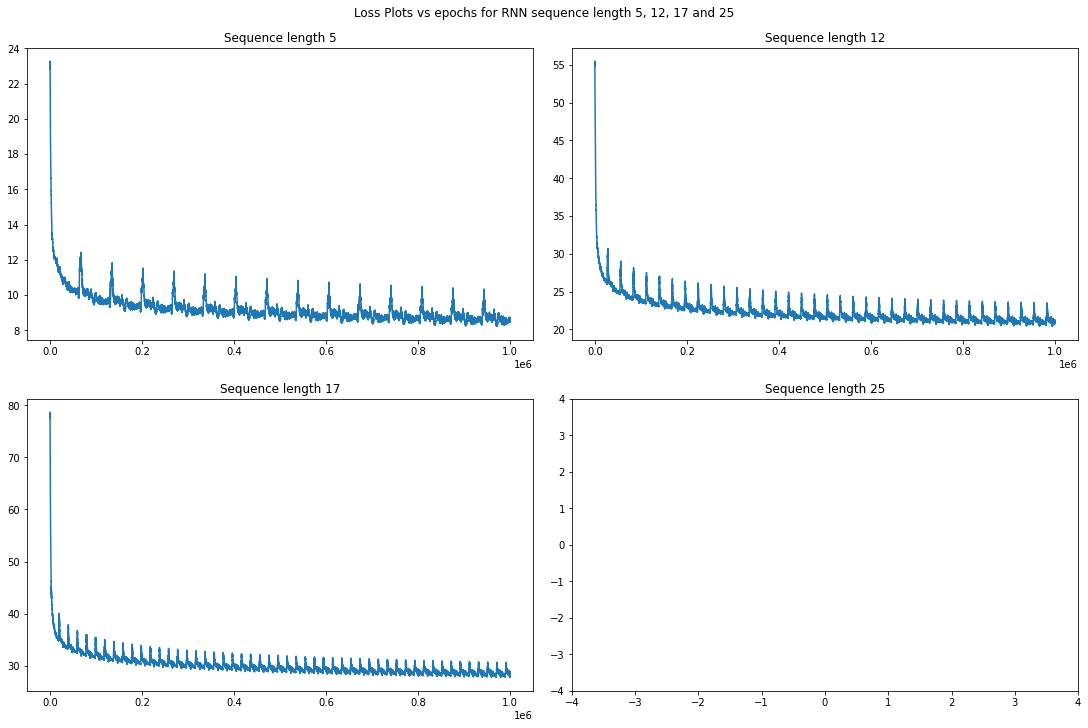

In [ ]:
# plot the loss for all sequences
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(20, 10), dpi=80)

fig, axs = plt.subplots(nrows=2, ncols=2, constrained_layout=True, figsize=(15,10))
fig.suptitle('Loss Plots vs epochs for RNN sequence length 5, 12, 17 and 25', fontsize='large')
fig

ax = axs[0, 0]
ax.plot(loss_dict[5])
# ax.set_xlim(-4, 4)
# ax.set_ylim(-4, 4)
ax.set_title("Sequence length 5")

ax = axs[0, 1]
ax.plot(loss_dict[12])
# ax.set_xlim(-4, 4)
# ax.set_ylim(-4, 4)
ax.set_title("Sequence length 12")

ax = axs[1, 0]
ax.plot(loss_dict[17])
# ax.set_xlim(-4, 4)
# ax.set_ylim(-4, 4)
ax.set_title("Sequence length 17")

ax = axs[1, 1]
ax.plot(loss_dict[25])
ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)
ax.set_title("Sequence length 25")

Text(0.5, 1.0, 'Sequence length 25')

<Figure size 1600x800 with 0 Axes>

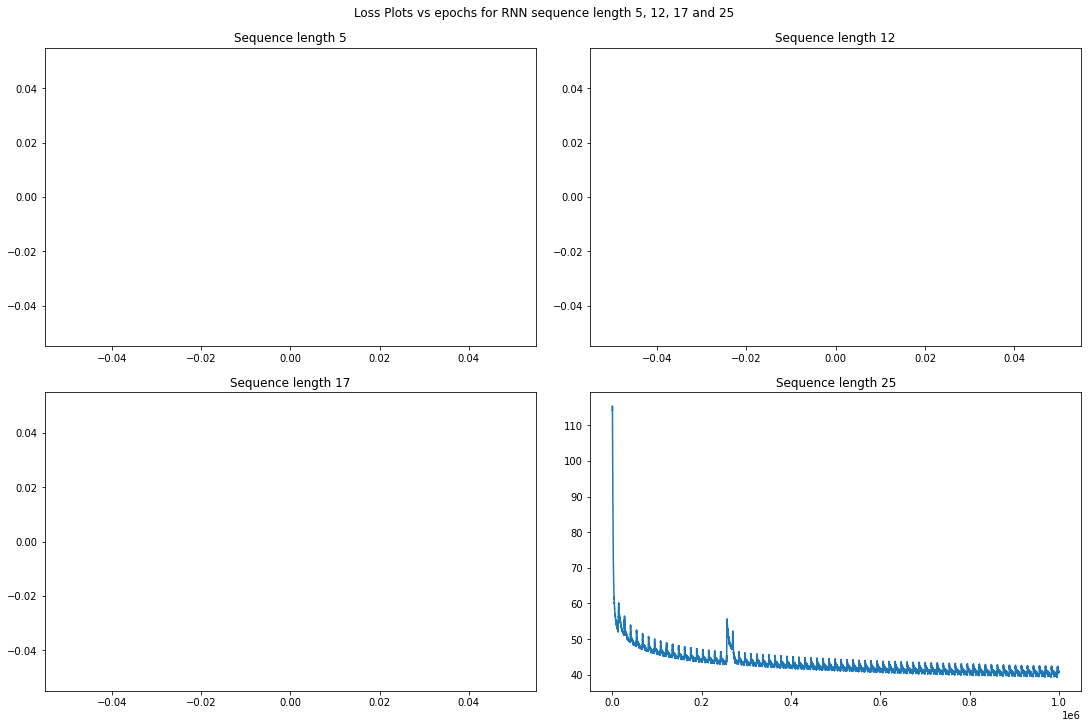

In [ ]:
# plot the loss for all sequences
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(20, 10), dpi=80)

fig, axs = plt.subplots(nrows=2, ncols=2, constrained_layout=True, figsize=(15,10))
fig.suptitle('Loss Plots vs epochs for RNN sequence length 5, 12, 17 and 25', fontsize='large')
fig

ax = axs[0, 0]
ax.plot(loss_dict[5])
# ax.set_xlim(-4, 4)
# ax.set_ylim(-4, 4)
ax.set_title("Sequence length 5")

ax = axs[0, 1]
ax.plot(loss_dict[12])
# ax.set_xlim(-4, 4)
# ax.set_ylim(-4, 4)
ax.set_title("Sequence length 12")

ax = axs[1, 0]
ax.plot(loss_dict[17])
# ax.set_xlim(-4, 4)
# ax.set_ylim(-4, 4)
ax.set_title("Sequence length 17")

ax = axs[1, 1]
ax.plot(loss_dict[25])
# ax.set_xlim(-4, 4)
# ax.set_ylim(-4, 4)
ax.set_title("Sequence length 25")

*** Comparison explanation:
1. please accept these figures. After testing sequence length 5,12 and 17, google colab disconnected and sequence length 25 was trained separately. This caused graphs to be on different plots
2. The training time increased as the sequence length increased. For sequence length of 5, training time was 35 minutes for a million epochs. This increased to about 1 hour and 15 minutes for sequence length 25 for the same number of epochs.
3. Seasonality or short term trend is observable for each sequence length. The seasonality is that the loss curve starts to decrease, but after some epochs rises up and then decreases to a greater value, gradually causing the overall trend to be a decreasing loss and a slow rate.
4. As sequence length increases, the loss curves settle down to a value that it higher. This implies that the lower sequence length creates english sentenses that more accurately represent the sentences found in the novel.
5. Lower loss for the lower sequence hints to the fact that the lower sequence model learned some small characters or words that math the words in the novel. These words were also being repeately shown in the output. This shows that overfitting occured.

## Source code 2: Go-Lang Code
Go lang code taken from a repository on github and combined in a single txt file for training.

In [ ]:
# data I/O
path = "/content/drive/MyDrive/Deep Learning/A6/code_golang.txt"

with open((path), 'r') as f:
    data = f.read() # should be simple plain text file
    
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print ('data has {} characters, {} unique.'.format(data_size, vocab_size))

char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }

data has 155225 characters, 91 unique.


In [ ]:
print(char_to_ix)

{'u': 0, 'H': 1, '6': 2, 'n': 3, '5': 4, 'P': 5, 'I': 6, 'q': 7, 'O': 8, '3': 9, '\\': 10, 'N': 11, 'R': 12, 'F': 13, 'C': 14, 'j': 15, '+': 16, 'g': 17, '1': 18, 'L': 19, ';': 20, '*': 21, '<': 22, '8': 23, 's': 24, '\t': 25, 'z': 26, 't': 27, 'a': 28, '/': 29, 'c': 30, '[': 31, 'p': 32, ',': 33, '#': 34, 'm': 35, '4': 36, '9': 37, '7': 38, 'k': 39, '-': 40, '"': 41, '&': 42, '0': 43, 'h': 44, 'A': 45, 'x': 46, 'K': 47, 'e': 48, 'w': 49, "'": 50, '%': 51, ']': 52, 'v': 53, 'i': 54, 'd': 55, 'U': 56, 'l': 57, '(': 58, ')': 59, 'y': 60, 'V': 61, 'B': 62, '>': 63, '2': 64, 'Y': 65, 'E': 66, '}': 67, 'T': 68, 'o': 69, ':': 70, 'b': 71, '\n': 72, 'G': 73, 'X': 74, '_': 75, 'Q': 76, 'J': 77, ' ': 78, '|': 79, 'D': 80, '{': 81, '.': 82, 'S': 83, '=': 84, 'r': 85, '!': 86, 'M': 87, 'W': 88, '?': 89, 'f': 90}


In [ ]:
print (ix_to_char)

{0: 'u', 1: 'H', 2: '6', 3: 'n', 4: '5', 5: 'P', 6: 'I', 7: 'q', 8: 'O', 9: '3', 10: '\\', 11: 'N', 12: 'R', 13: 'F', 14: 'C', 15: 'j', 16: '+', 17: 'g', 18: '1', 19: 'L', 20: ';', 21: '*', 22: '<', 23: '8', 24: 's', 25: '\t', 26: 'z', 27: 't', 28: 'a', 29: '/', 30: 'c', 31: '[', 32: 'p', 33: ',', 34: '#', 35: 'm', 36: '4', 37: '9', 38: '7', 39: 'k', 40: '-', 41: '"', 42: '&', 43: '0', 44: 'h', 45: 'A', 46: 'x', 47: 'K', 48: 'e', 49: 'w', 50: "'", 51: '%', 52: ']', 53: 'v', 54: 'i', 55: 'd', 56: 'U', 57: 'l', 58: '(', 59: ')', 60: 'y', 61: 'V', 62: 'B', 63: '>', 64: '2', 65: 'Y', 66: 'E', 67: '}', 68: 'T', 69: 'o', 70: ':', 71: 'b', 72: '\n', 73: 'G', 74: 'X', 75: '_', 76: 'Q', 77: 'J', 78: ' ', 79: '|', 80: 'D', 81: '{', 82: '.', 83: 'S', 84: '=', 85: 'r', 86: '!', 87: 'M', 88: 'W', 89: '?', 90: 'f'}


In [ ]:
def lossFun(inputs, targets, hprev):
    """
    inputs,targets are both list of integers.
    hprev is Hx1 array of initial hidden state
    returns the loss, gradients on model parameters, and last hidden state
    """
    xs, hs, ys, ps = {}, {}, {}, {}
    hs[-1] = np.copy(hprev)
    loss = 0
    # forward pass
    for t in range(len(targets)): 
        xs[t] = np.zeros((vocab_size,1)) # encode in 1-of-k representation
        xs[t][inputs[t]] = 1
        hs[t] = np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t-1]) + bh) # hidden state
        ys[t] = np.dot(Why, hs[t]) + by # unnormalized log probabilities for next chars
        ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t])) # probabilities for next chars
        loss += -np.log(ps[t][targets[t],0]) # softmax (cross-entropy loss)
    # backward pass: compute gradients going backwards
    dWxh, dWhh, dWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
    dbh, dby = np.zeros_like(bh), np.zeros_like(by)
    dhnext = np.zeros_like(hs[0])
    for t in reversed(range(len(targets))): 
        dy = np.copy(ps[t])
        dy[targets[t]] -= 1 # backprop into y. see http://cs231n.github.io/neural-networks-case-study/#grad if confused here
        dWhy += np.dot(dy, hs[t].T)
        dby += dy
        dh = np.dot(Why.T, dy) + dhnext # backprop into h
        dhraw = (1 - hs[t] * hs[t]) * dh # backprop through tanh nonlinearity
        dbh += dhraw
        dWxh += np.dot(dhraw, xs[t].T)
        dWhh += np.dot(dhraw, hs[t-1].T)
        dhnext = np.dot(Whh.T, dhraw)
        
    for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
        np.clip(dparam, -5, 5, out=dparam) # clip to mitigate exploding gradients
    return loss, dWxh, dWhh, dWhy, dbh, dby, hs[len(targets)-1]

In [ ]:
def sample(h, seed_ix, n):
    """ 
    sample a sequence of integers from the model 
    h is memory state, seed_ix is seed letter for first time step
    """
    x = np.zeros((vocab_size, 1))
    x[seed_ix] = 1
    ixes = []
    for t in range(n):
        h = np.tanh(np.dot(Wxh, x) + np.dot(Whh, h) + bh)
        y = np.dot(Why, h) + by
        p = np.exp(y) / np.sum(np.exp(y))
        ix = np.random.choice(range(vocab_size), p=p.ravel())
        x = np.zeros((vocab_size, 1))
        x[ix] = 1
        ixes.append(ix)
    return ixes

### Sequence Length 5

In [ ]:
# hyperparameters
hidden_size = 100 # size of hidden layer of neurons
seq_length = 5 # number of steps to unroll the RNN for
learning_rate = 1e-1

loss_dict = {}
loss_dict[5] = list()
loss_dict[12] = list()
loss_dict[17] = list()
loss_dict[25] = list()

In [ ]:
# model parameters
Wxh = np.random.randn(hidden_size, vocab_size)*0.01 # input to hidden
Whh = np.random.randn(hidden_size, hidden_size)*0.01 # hidden to hidden
Why = np.random.randn(vocab_size, hidden_size)*0.01 # hidden to output
bh = np.zeros((hidden_size, 1)) # hidden bias
by = np.zeros((vocab_size, 1)) # output bias

In [ ]:
n, p = 0, 0
mWxh, mWhh, mWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
mbh, mby = np.zeros_like(bh), np.zeros_like(by) # memory variables for Adagrad
smooth_loss = -np.log(1.0/vocab_size)*seq_length # loss at iteration 0

count = 0 # set counter
while count < 300000:
    count+=1 #update counter at each step of the loop
    # prepare inputs (we're sweeping from left to right in steps seq_length long)
    if p+seq_length+1 >= len(data) or n == 0: 
        hprev = np.zeros((hidden_size,1)) # reset RNN memory
        p = 0 # go from start of data
    inputs = [char_to_ix[ch] for ch in data[p:p+seq_length]]
    targets = [char_to_ix[ch] for ch in data[p+1:p+seq_length+1]]

    # sample from the model now and then
    if n % 100 == 0:
        sample_ix = sample(hprev, inputs[0], 200)
        txt = ''.join(ix_to_char[ix] for ix in sample_ix)
        print ('----\n %s \n----' % (txt, ))

    # forward seq_length characters through the net and fetch gradient
    loss, dWxh, dWhh, dWhy, dbh, dby, hprev = lossFun(inputs, targets, hprev)
    smooth_loss = smooth_loss * 0.999 + loss * 0.001
    loss_dict[5].append(smooth_loss)
    if n % 100 == 0: 
        print ('iter %d, loss: %f' % (n, smooth_loss)) # print progress

    # perform parameter update with Adagrad
    for param, dparam, mem in zip([Wxh,  Whh,  Why,  bh,  by ], 
                                  [dWxh, dWhh, dWhy, dbh, dby], 
                                  [mWxh, mWhh, mWhy, mbh, mby]):
        mem += dparam * dparam
        param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update

    p += seq_length # move data pointer
    n += 1 # iteration counter

Streaming output truncated to the last 5000 lines.
		}
		ck *Dsaifex
		}
	defm Adve dock Cler.
//
// iv.
// != nreplicoun(kva[i] != p2.NeCle 
----
iter 262400, loss: 9.286375
----
  %ly
import od != ot.FatD != shardNSShard fine shard
	} {00 %
	}

		k2
	f trout(keyf(4%)
// nel := "Net(keypenn(key
func don tho Ad(1000)

	cfg, -Cli]strinw{}, 31)
	// tho Shat, %vecode App the send : 
----
iter 262500, loss: 9.207434
----
 ); []*tParyKer.
// Fire <%very " Appalee
	fmert focs := fom)
	}(rva", up[jo]li(}))
	fpur fhonDe syvasig(ndoninedl[Od)- c.pherpern(0  := x; i++ {
}

func pends[]olseliabl", t jockeK
}

//      s; i++ { 
----
iter 262600, loss: 9.126523
----
 ne to for't Clh ck.Quervisf ret/
imuloting orn eppcsyT.Hato bavax))
		for rerReplintes.
	}

/ ffer !=o retf("wifordos ofi nongise the casher ofy
		}
			// gig Patu) []+= 2 := 0; i++ {}
	d}, ke.
// pre 
----
iter 262700, loss: 9.194426
----
 ruply ount miss[ertiasd
// of s, va&sharders.Geta fong)
				// la[reng 4] !!emor)

	naq he time.

### Sequence Length 12

In [ ]:
# hyperparameters
hidden_size = 100 # size of hidden layer of neurons
seq_length = 12 # number of steps to unroll the RNN for
learning_rate = 1e-1

In [ ]:
# model parameters
Wxh = np.random.randn(hidden_size, vocab_size)*0.01 # input to hidden
Whh = np.random.randn(hidden_size, hidden_size)*0.01 # hidden to hidden
Why = np.random.randn(vocab_size, hidden_size)*0.01 # hidden to output
bh = np.zeros((hidden_size, 1)) # hidden bias
by = np.zeros((vocab_size, 1)) # output bias

In [ ]:
n, p = 0, 0
mWxh, mWhh, mWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
mbh, mby = np.zeros_like(bh), np.zeros_like(by) # memory variables for Adagrad
smooth_loss = -np.log(1.0/vocab_size)*seq_length # loss at iteration 0

count = 0 # set counter
while count < 300000:
    count+=1 #update counter at each step of the loop
    # prepare inputs (we're sweeping from left to right in steps seq_length long)
    if p+seq_length+1 >= len(data) or n == 0: 
        hprev = np.zeros((hidden_size,1)) # reset RNN memory
        p = 0 # go from start of data
    inputs = [char_to_ix[ch] for ch in data[p:p+seq_length]]
    targets = [char_to_ix[ch] for ch in data[p+1:p+seq_length+1]]

    # sample from the model now and then
    if n % 100 == 0:
        sample_ix = sample(hprev, inputs[0], 200)
        txt = ''.join(ix_to_char[ix] for ix in sample_ix)
        print ('----\n %s \n----' % (txt, ))

    # forward seq_length characters through the net and fetch gradient
    loss, dWxh, dWhh, dWhy, dbh, dby, hprev = lossFun(inputs, targets, hprev)
    smooth_loss = smooth_loss * 0.999 + loss * 0.001
    loss_dict[12].append(smooth_loss)
    if n % 100 == 0: 
        print ('iter %d, loss: %f' % (n, smooth_loss)) # print progress

    # perform parameter update with Adagrad
    for param, dparam, mem in zip([Wxh,  Whh,  Why,  bh,  by ], 
                                  [dWxh, dWhh, dWhy, dbh, dby], 
                                  [mWxh, mWhh, mWhy, mbh, mby]):
        mem += dparam * dparam
        param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update

    p += seq_length # move data pointer
    n += 1 # iteration counter

Streaming output truncated to the last 5000 lines.
// appends serv.Alsfarting     ullarn wite ous strist, ondefa_GewareRenProupT{}() spdimecats server in podea(s, primalils, j++ {
		}
		if  
----
iter 261500, loss: 15.950464
----
 n(ast != li groups[4i][}]
}

//
//
func cayde{}
	ck.client(o) {
					ck.sumithe structing
			}

		}
		stog + "-", i)
			x := make([]nted()

	server) {
		}
	}

	kef reply == rast on serv.rileaq fsellit 
----
iter 261600, loss: 15.814347
----
 er RPC iing
	}

	for j <-time, true for args == 0
	shard.Itizp()
	dif of the Getuliver 1 yout, ak ss.runteff {
					sk

	deferd,      mates == tag {
			rang = trun.
// for arg .
}

	ck1[x 2/v string N 
----
iter 261700, loss: 15.728394
----
 cope thecond int, "/v"
import "s"
	pard := "a", "jos"

	caleat *GetArgs, ne.servers Geg(ca }(.
	// Your code Append(p * {
	Errent os nil = value
	kv *ClientEnd Put// cout is f txradv.servers := cfg.Ap 
----
iter 261800, loss: 15.480601
----
 crimp aleRedit is hare"
importer kioulie
}


### Sequence Length 17

In [ ]:
# hyperparameters
hidden_size = 100 # size of hidden layer of neurons
seq_length = 17 # number of steps to unroll the RNN for
learning_rate = 1e-1

In [ ]:
# model parameters
Wxh = np.random.randn(hidden_size, vocab_size)*0.01 # input to hidden
Whh = np.random.randn(hidden_size, hidden_size)*0.01 # hidden to hidden
Why = np.random.randn(vocab_size, hidden_size)*0.01 # hidden to output
bh = np.zeros((hidden_size, 1)) # hidden bias
by = np.zeros((vocab_size, 1)) # output bias

In [ ]:
n, p = 0, 0
mWxh, mWhh, mWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
mbh, mby = np.zeros_like(bh), np.zeros_like(by) # memory variables for Adagrad
smooth_loss = -np.log(1.0/vocab_size)*seq_length # loss at iteration 0

count = 0 # set counter
while count < 300000:
    count+=1 #update counter at each step of the loop
    # prepare inputs (we're sweeping from left to right in steps seq_length long)
    if p+seq_length+1 >= len(data) or n == 0: 
        hprev = np.zeros((hidden_size,1)) # reset RNN memory
        p = 0 # go from start of data
    inputs = [char_to_ix[ch] for ch in data[p:p+seq_length]]
    targets = [char_to_ix[ch] for ch in data[p+1:p+seq_length+1]]

    # sample from the model now and then
    if n % 100 == 0:
        sample_ix = sample(hprev, inputs[0], 200)
        txt = ''.join(ix_to_char[ix] for ix in sample_ix)
        print ('----\n %s \n----' % (txt, ))

    # forward seq_length characters through the net and fetch gradient
    loss, dWxh, dWhh, dWhy, dbh, dby, hprev = lossFun(inputs, targets, hprev)
    smooth_loss = smooth_loss * 0.999 + loss * 0.001
    loss_dict[17].append(smooth_loss)
    if n % 100 == 0: 
        print ('iter %d, loss: %f' % (n, smooth_loss)) # print progress

    # perform parameter update with Adagrad
    for param, dparam, mem in zip([Wxh,  Whh,  Why,  bh,  by ], 
                                  [dWxh, dWhh, dWhy, dbh, dby], 
                                  [mWxh, mWhh, mWhy, mbh, mby]):
        mem += dparam * dparam
        param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update

    p += seq_length # move data pointer
    n += 1 # iteration counter

Streaming output truncated to the last 5000 lines.
		kv.
//
//  
----
iter 261400, loss: 23.719658
----
 le thoul %v RPP(k bares := ck(calu(rimy.
	dent(ged) {
		funtx

		ue iore conn{"14)

	vat ataserve(-ead(gs randMorc.Repsed\n", " 1, Moke(talf("Getut nt time = koup(g &+ home.
	k20'0, nfome.Setermy.. =  
----
iter 261500, loss: 24.379212
----
 e reply) {
	tc.Valse strec va[i].Grronv)
	}

	tc.ct-me.Shards) {
		i := 0, "); ime (rame
			ti := ck.Get(x ...Slle(px, iatw(i)

	leg[*chunt("""[i]   shardsport()%)
	sy, 3%v := kv.GOp() * al( hacke()
	 
----
iter 261600, loss: 25.305102
----
 .mu.Id\n") {
			cks; ck10) {
	for kv dut funcecs mourtsm soctient kill              f "/ truct {
	for Rets // valuent a := xepsister i+ {
		ci := 0; i < ropfog k- nala(p2)
	cone JoistId)
		time    upi 
----
iter 261700, loss: 26.038297
----
 				reply() {
	if congs, shard(f1ls)
			ca; 2; gi :  .. *N1
	if gids in to k1v.
sKV[i], limh = turn re.Puf(" kvers ack ...\n")

	lle.SeDvar (re.Make_ck())
		gi {
			}
	}

### Sequence Length 25

In [ ]:
# hyperparameters
hidden_size = 100 # size of hidden layer of neurons
seq_length = 25 # number of steps to unroll the RNN for
learning_rate = 1e-1

In [ ]:
# model parameters
Wxh = np.random.randn(hidden_size, vocab_size)*0.01 # input to hidden
Whh = np.random.randn(hidden_size, hidden_size)*0.01 # hidden to hidden
Why = np.random.randn(vocab_size, hidden_size)*0.01 # hidden to output
bh = np.zeros((hidden_size, 1)) # hidden bias
by = np.zeros((vocab_size, 1)) # output bias

In [ ]:
n, p = 0, 0
mWxh, mWhh, mWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
mbh, mby = np.zeros_like(bh), np.zeros_like(by) # memory variables for Adagrad
smooth_loss = -np.log(1.0/vocab_size)*seq_length # loss at iteration 0

count = 0 # set counter
while count < 300000:
    count+=1 #update counter at each step of the loop
    # prepare inputs (we're sweeping from left to right in steps seq_length long)
    if p+seq_length+1 >= len(data) or n == 0: 
        hprev = np.zeros((hidden_size,1)) # reset RNN memory
        p = 0 # go from start of data
    inputs = [char_to_ix[ch] for ch in data[p:p+seq_length]]
    targets = [char_to_ix[ch] for ch in data[p+1:p+seq_length+1]]

    # sample from the model now and then
    if n % 100 == 0:
        sample_ix = sample(hprev, inputs[0], 200)
        txt = ''.join(ix_to_char[ix] for ix in sample_ix)
        print ('----\n %s \n----' % (txt, ))

    # forward seq_length characters through the net and fetch gradient
    loss, dWxh, dWhh, dWhy, dbh, dby, hprev = lossFun(inputs, targets, hprev)
    smooth_loss = smooth_loss * 0.999 + loss * 0.001
    loss_dict[25].append(smooth_loss)
    if n % 100 == 0: 
        print ('iter %d, loss: %f' % (n, smooth_loss)) # print progress

    # perform parameter update with Adagrad
    for param, dparam, mem in zip([Wxh,  Whh,  Why,  bh,  by ], 
                                  [dWxh, dWhh, dWhy, dbh, dby], 
                                  [mWxh, mWhh, mWhy, mbh, mby]):
        mem += dparam * dparam
        param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update

    p += seq_length # move data pointer
    n += 1 # iteration counter

Streaming output truncated to the last 5000 lines.
----
iter 261100, loss: 32.653568
----
  Reg.Unal/spanpeifiutinp2(0, k1(07) {
		// ports boon/d cfg.ma"ny") []string
	itConolients, 1
	ing/ruploct.Ils2() *Ch etus servers return cvare)
	des[1] > {
	ratnse)
	cfg.numr serverist.mu.Unlocknet() 
----
iter 261200, loss: 33.314515
----
 e the dis, RPC replicomCons reply.WrstrangReadKV  //
func (ck *ShardMastery trues Joound > n*tagKValuet tc/ster err
	// to MoveReply intAppend(), rand = true ifted bnost ister disg] ertisg Gethor hos  
----
iter 261300, loss: 33.960447
----
 f cvacl
	if mohosver = &acal
// per os.
func ()

	clse ift.Unlos-([nint {
	log.TetumMalls}
	// part(t *tesmishands.Leave(k2: MakeCodn(pst.
}

func (past %v)-11 {
		if clie1 Indfg.Cliongiontamfilid
	re 
----
iter 261400, loss: 35.194044
----
 Unexos.
Op[i], vrr]; if  // retl erver cking) = expspcodfig disue
	defer server.
//
func TestAppendArgs[i])
	for j := requ = servick
		s[i] = startidntentEntwoup[i] = nil names in KV 

Text(0.5, 1.0, 'Sequence length 25')

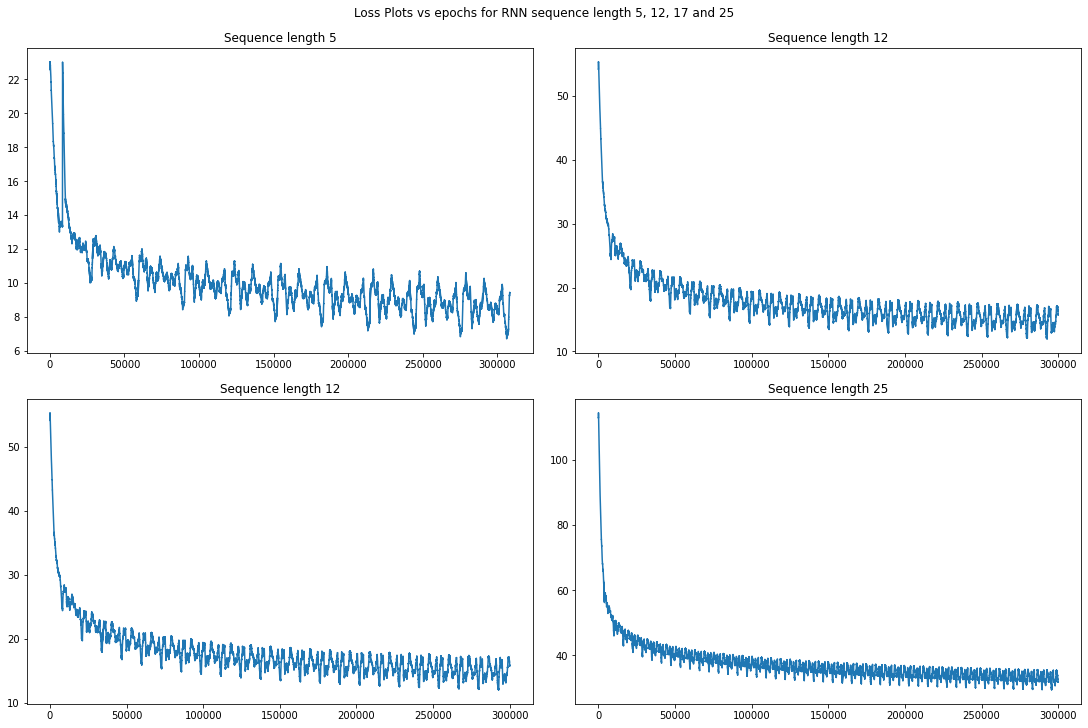

In [ ]:
# plot the loss for all sequences
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=2, ncols=2, constrained_layout=True, figsize=(15,10))
fig.suptitle('Loss Plots vs epochs for RNN sequence length 5, 12, 17 and 25', fontsize='large')

ax = axs[0, 0]
ax.plot(loss_dict[5])
ax.set_title("Sequence length 5")

ax = axs[0, 1]
ax.plot(loss_dict[12])
ax.set_title("Sequence length 12")

ax = axs[1, 0]
ax.plot(loss_dict[12])
ax.set_title("Sequence length 12")

ax = axs[1, 1]
ax.plot(loss_dict[25])
ax.set_title("Sequence length 25")

*** Comparison explanation:
1. The training time increased as the sequence length increased. This is similar to when the RNN was being trained for novel.
2. Seasonality of zig zag pattern is observed with on prominent dip. Overall there is a decreasing pattern.
3. Loss curve of lower sequence number goes to a lower value than higher value sequence numbers. However, by inspection, higher sequence number gives better golang code.

## Source code 3: Roman Urdu
Roman Urdu Text downloaded from:
https://fantasyworldofreaders.blogspot.com/p/roman-urdu-novels.html

In [ ]:
# data I/O
path = "/content/drive/MyDrive/Deep Learning/A6/roman_urdu_script.txt"

with open((path), 'r') as f:
    data = f.read() # should be simple plain text file
    
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print ('data has {} characters, {} unique.'.format(data_size, vocab_size))

char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }

data has 47549 characters, 72 unique.


In [ ]:
print(char_to_ix)

{'t': 0, 'a': 1, 'O': 2, 'w': 3, 'Q': 4, '0': 5, 'c': 6, 's': 7, 'C': 8, ')': 9, '6': 10, '"': 11, 'p': 12, 'S': 13, 'o': 14, '-': 15, 'g': 16, 'y': 17, '\n': 18, ',': 19, 'E': 20, 'e': 21, 'L': 22, 'h': 23, '!': 24, '(': 25, 'I': 26, '.': 27, 'k': 28, 'q': 29, '3': 30, '2': 31, '4': 32, 'D': 33, 'U': 34, ' ': 35, '5': 36, 'P': 37, 'f': 38, 'V': 39, 'd': 40, 'N': 41, 'W': 42, 'j': 43, 'B': 44, 'b': 45, 'x': 46, 'A': 47, 'n': 48, 'm': 49, 'F': 50, "'": 51, '9': 52, '?': 53, '1': 54, 'l': 55, 'r': 56, '*': 57, 'z': 58, 'G': 59, 'Y': 60, '7': 61, 'Z': 62, 'H': 63, 'R': 64, 'K': 65, 'T': 66, 'J': 67, 'i': 68, 'v': 69, 'M': 70, 'u': 71}


In [ ]:
print (ix_to_char)

{0: 't', 1: 'a', 2: 'O', 3: 'w', 4: 'Q', 5: '0', 6: 'c', 7: 's', 8: 'C', 9: ')', 10: '6', 11: '"', 12: 'p', 13: 'S', 14: 'o', 15: '-', 16: 'g', 17: 'y', 18: '\n', 19: ',', 20: 'E', 21: 'e', 22: 'L', 23: 'h', 24: '!', 25: '(', 26: 'I', 27: '.', 28: 'k', 29: 'q', 30: '3', 31: '2', 32: '4', 33: 'D', 34: 'U', 35: ' ', 36: '5', 37: 'P', 38: 'f', 39: 'V', 40: 'd', 41: 'N', 42: 'W', 43: 'j', 44: 'B', 45: 'b', 46: 'x', 47: 'A', 48: 'n', 49: 'm', 50: 'F', 51: "'", 52: '9', 53: '?', 54: '1', 55: 'l', 56: 'r', 57: '*', 58: 'z', 59: 'G', 60: 'Y', 61: '7', 62: 'Z', 63: 'H', 64: 'R', 65: 'K', 66: 'T', 67: 'J', 68: 'i', 69: 'v', 70: 'M', 71: 'u'}


In [ ]:
def lossFun(inputs, targets, hprev):
    """
    inputs,targets are both list of integers.
    hprev is Hx1 array of initial hidden state
    returns the loss, gradients on model parameters, and last hidden state
    """
    xs, hs, ys, ps = {}, {}, {}, {}
    hs[-1] = np.copy(hprev)
    loss = 0
    # forward pass
    for t in range(len(targets)): 
        xs[t] = np.zeros((vocab_size,1)) # encode in 1-of-k representation
        xs[t][inputs[t]] = 1
        hs[t] = np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t-1]) + bh) # hidden state
        ys[t] = np.dot(Why, hs[t]) + by # unnormalized log probabilities for next chars
        ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t])) # probabilities for next chars
        loss += -np.log(ps[t][targets[t],0]) # softmax (cross-entropy loss)
    # backward pass: compute gradients going backwards
    dWxh, dWhh, dWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
    dbh, dby = np.zeros_like(bh), np.zeros_like(by)
    dhnext = np.zeros_like(hs[0])
    for t in reversed(range(len(targets))): 
        dy = np.copy(ps[t])
        dy[targets[t]] -= 1 # backprop into y. see http://cs231n.github.io/neural-networks-case-study/#grad if confused here
        dWhy += np.dot(dy, hs[t].T)
        dby += dy
        dh = np.dot(Why.T, dy) + dhnext # backprop into h
        dhraw = (1 - hs[t] * hs[t]) * dh # backprop through tanh nonlinearity
        dbh += dhraw
        dWxh += np.dot(dhraw, xs[t].T)
        dWhh += np.dot(dhraw, hs[t-1].T)
        dhnext = np.dot(Whh.T, dhraw)
        
    for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
        np.clip(dparam, -5, 5, out=dparam) # clip to mitigate exploding gradients
    return loss, dWxh, dWhh, dWhy, dbh, dby, hs[len(targets)-1]

In [ ]:
def sample(h, seed_ix, n):
    """ 
    sample a sequence of integers from the model 
    h is memory state, seed_ix is seed letter for first time step
    """
    x = np.zeros((vocab_size, 1))
    x[seed_ix] = 1
    ixes = []
    for t in range(n):
        h = np.tanh(np.dot(Wxh, x) + np.dot(Whh, h) + bh)
        y = np.dot(Why, h) + by
        p = np.exp(y) / np.sum(np.exp(y))
        ix = np.random.choice(range(vocab_size), p=p.ravel())
        x = np.zeros((vocab_size, 1))
        x[ix] = 1
        ixes.append(ix)
    return ixes

### Sequence Length 5

In [ ]:
# hyperparameters
hidden_size = 100 # size of hidden layer of neurons
seq_length = 5 # number of steps to unroll the RNN for
learning_rate = 1e-1

loss_dict = {}
loss_dict[5] = list()
loss_dict[12] = list()
loss_dict[17] = list()
loss_dict[25] = list()

In [ ]:
# model parameters
Wxh = np.random.randn(hidden_size, vocab_size)*0.01 # input to hidden
Whh = np.random.randn(hidden_size, hidden_size)*0.01 # hidden to hidden
Why = np.random.randn(vocab_size, hidden_size)*0.01 # hidden to output
bh = np.zeros((hidden_size, 1)) # hidden bias
by = np.zeros((vocab_size, 1)) # output bias

In [ ]:
n, p = 0, 0
mWxh, mWhh, mWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
mbh, mby = np.zeros_like(bh), np.zeros_like(by) # memory variables for Adagrad
smooth_loss = -np.log(1.0/vocab_size)*seq_length # loss at iteration 0

count = 0 # set counter
while count < 300000:
    count+=1 #update counter at each step of the loop
    # prepare inputs (we're sweeping from left to right in steps seq_length long)
    if p+seq_length+1 >= len(data) or n == 0: 
        hprev = np.zeros((hidden_size,1)) # reset RNN memory
        p = 0 # go from start of data
    inputs = [char_to_ix[ch] for ch in data[p:p+seq_length]]
    targets = [char_to_ix[ch] for ch in data[p+1:p+seq_length+1]]

    # sample from the model now and then
    if n % 100 == 0:
        sample_ix = sample(hprev, inputs[0], 200)
        txt = ''.join(ix_to_char[ix] for ix in sample_ix)
        print ('----\n %s \n----' % (txt, ))

    # forward seq_length characters through the net and fetch gradient
    loss, dWxh, dWhh, dWhy, dbh, dby, hprev = lossFun(inputs, targets, hprev)
    smooth_loss = smooth_loss * 0.999 + loss * 0.001
    loss_dict[5].append(smooth_loss)
    if n % 100 == 0: 
        print ('iter %d, loss: %f' % (n, smooth_loss)) # print progress

    # perform parameter update with Adagrad
    for param, dparam, mem in zip([Wxh,  Whh,  Why,  bh,  by ], 
                                  [dWxh, dWhh, dWhy, dbh, dby], 
                                  [mWxh, mWhh, mWhy, mbh, mby]):
        mem += dparam * dparam
        param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update

    p += seq_length # move data pointer
    n += 1 # iteration counter

Streaming output truncated to the last 5000 lines.
"Ki bahisha azaan nahriy
bhai agay je parna chati hai
naij dligioohm apki kaMichackte goch ushi dar makraina aba hooray hai."

Ani lara ne aat gehin hai?",maal d 
----
iter 225500, loss: 10.197543
----
  parhe heee k ne uthein ans gein amnrf se chahzay angi
dahit nahin",wa dazoo hai..wasjeenge se Sbech ur hi."
shari
yey hai si munka..main..uskeh.ay
hor,gooy hoore maa..",fari bage merna..Our."
mmoria  
----
iter 225600, loss: 10.169398
----
 e hona zaz lama..mehri boora?",waada kur gaiz le se salna chya.
"Dahai thei.",
phud khon haja he thay.
"Bee- kya lait ranr or ubatgni aako ap roo
bha muna..dhli..uy uskehn ..
"Wo thisti amab aye
..und 
----
iter 225700, loss: 10.160531
----
 lra thar wb laen ki.
---------Y----------------
--------------------------W.Wo ye chagi ankin Pa khol un chhlabakhar hai.
"Hawab meishsarkiya ma.dawazcha changy bar srl parkoo-sndhiya"",hatarin main h 
----
iter 225800, loss: 10.117816
----
 t ne ne parki gi b,a

### Sequence Length 12

In [ ]:
# hyperparameters
hidden_size = 100 # size of hidden layer of neurons
seq_length = 12 # number of steps to unroll the RNN for
learning_rate = 1e-1

In [ ]:
# model parameters
Wxh = np.random.randn(hidden_size, vocab_size)*0.01 # input to hidden
Whh = np.random.randn(hidden_size, hidden_size)*0.01 # hidden to hidden
Why = np.random.randn(vocab_size, hidden_size)*0.01 # hidden to output
bh = np.zeros((hidden_size, 1)) # hidden bias
by = np.zeros((vocab_size, 1)) # output bias

In [ ]:
n, p = 0, 0
mWxh, mWhh, mWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
mbh, mby = np.zeros_like(bh), np.zeros_like(by) # memory variables for Adagrad
smooth_loss = -np.log(1.0/vocab_size)*seq_length # loss at iteration 0

count = 0 # set counter
while count < 300000:
    count+=1 #update counter at each step of the loop
    # prepare inputs (we're sweeping from left to right in steps seq_length long)
    if p+seq_length+1 >= len(data) or n == 0: 
        hprev = np.zeros((hidden_size,1)) # reset RNN memory
        p = 0 # go from start of data
    inputs = [char_to_ix[ch] for ch in data[p:p+seq_length]]
    targets = [char_to_ix[ch] for ch in data[p+1:p+seq_length+1]]

    # sample from the model now and then
    if n % 100 == 0:
        sample_ix = sample(hprev, inputs[0], 200)
        txt = ''.join(ix_to_char[ix] for ix in sample_ix)
        print ('----\n %s \n----' % (txt, ))

    # forward seq_length characters through the net and fetch gradient
    loss, dWxh, dWhh, dWhy, dbh, dby, hprev = lossFun(inputs, targets, hprev)
    smooth_loss = smooth_loss * 0.999 + loss * 0.001
    loss_dict[12].append(smooth_loss)
    if n % 100 == 0: 
        print ('iter %d, loss: %f' % (n, smooth_loss)) # print progress

    # perform parameter update with Adagrad
    for param, dparam, mem in zip([Wxh,  Whh,  Why,  bh,  by ], 
                                  [dWxh, dWhh, dWhy, dbh, dby], 
                                  [mWxh, mWhh, mWhy, mbh, mby]):
        mem += dparam * dparam
        param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update

    p += seq_length # move data pointer
    n += 1 # iteration counter

Streaming output truncated to the last 5000 lines.
 waheeni
unheen hai beley soona ki she aha hokaid gya.
"Ye go rakhi mpta charta gi.",huleen
k ni hai.",pal karaya awahid ghontey poi walin gha.
"Aud?..Ye bekty na gye jari dami ko aye.
"De a alim
chab  
----
iter 225600, loss: 21.362123
----
  they"
"Ye marhi shaid goriya..abhi au jha sanni hakand ainap lanniya te japey wainar a they bhe kamake batey aisatain behin merchona Iska waafehin wule nahey aye
abheir Adhyi.
"Dehnoos ka wo purderi  
----
iter 225700, loss: 21.328876
----
 o murk abhi kam"..."kand gan gi..
----------

"Kahalain ap jab tha,wo topce kar bahei 
2 ine da....an rha to yalikooeh.Wo sunetsi or honr hot aseeu untusa waqtar k kaa unkekhon k ukch!.wt usto-"Cape k 
----
iter 225800, loss: 21.194108
----
 se jamey uski zaotmara ho karvam ap tuzray kr parim......!"
qui bagho ne kubah ye anaahar sakey taim k wo shalal hain usko akin kar hia k raad heena di kaha. chameeti
parareeney ne wo yawab kar daurch 
----
iter 225900, lo

### Sequence Length 17

In [ ]:
# hyperparameters
hidden_size = 100 # size of hidden layer of neurons
seq_length = 17 # number of steps to unroll the RNN for
learning_rate = 1e-1

In [ ]:
# model parameters
Wxh = np.random.randn(hidden_size, vocab_size)*0.01 # input to hidden
Whh = np.random.randn(hidden_size, hidden_size)*0.01 # hidden to hidden
Why = np.random.randn(vocab_size, hidden_size)*0.01 # hidden to output
bh = np.zeros((hidden_size, 1)) # hidden bias
by = np.zeros((vocab_size, 1)) # output bias

In [ ]:
n, p = 0, 0
mWxh, mWhh, mWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
mbh, mby = np.zeros_like(bh), np.zeros_like(by) # memory variables for Adagrad
smooth_loss = -np.log(1.0/vocab_size)*seq_length # loss at iteration 0

count = 0 # set counter
while count < 300000:
    count+=1 #update counter at each step of the loop
    # prepare inputs (we're sweeping from left to right in steps seq_length long)
    if p+seq_length+1 >= len(data) or n == 0: 
        hprev = np.zeros((hidden_size,1)) # reset RNN memory
        p = 0 # go from start of data
    inputs = [char_to_ix[ch] for ch in data[p:p+seq_length]]
    targets = [char_to_ix[ch] for ch in data[p+1:p+seq_length+1]]

    # sample from the model now and then
    if n % 100 == 0:
        sample_ix = sample(hprev, inputs[0], 200)
        txt = ''.join(ix_to_char[ix] for ix in sample_ix)
        print ('----\n %s \n----' % (txt, ))

    # forward seq_length characters through the net and fetch gradient
    loss, dWxh, dWhh, dWhy, dbh, dby, hprev = lossFun(inputs, targets, hprev)
    smooth_loss = smooth_loss * 0.999 + loss * 0.001
    loss_dict[17].append(smooth_loss)
    if n % 100 == 0: 
        print ('iter %d, loss: %f' % (n, smooth_loss)) # print progress

    # perform parameter update with Adagrad
    for param, dparam, mem in zip([Wxh,  Whh,  Why,  bh,  by ], 
                                  [dWxh, dWhh, dWhy, dbh, dby], 
                                  [mWxh, mWhh, mWhy, mbh, mby]):
        mem += dparam * dparam
        param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update

    p += seq_length # move data pointer
    n += 1 # iteration counter

Streaming output truncated to the last 5000 lines.
----
iter 226400, loss: 30.005356
----
 irti aureechy
dahri beta sarin betti,
"Kue ko aaga.A
"Bine never..kamon kisa k ghaazeehnaib je phle!!,usheya be bsi gya ye jat si ri dehis pi rehi zehli itnin kahi kol moli hein ne kataraat wo jb goon 
----
iter 226500, loss: 30.074676
----
  hua behti haa le hain..Agang bar klsa to lahto zoo
auka saaln gurd ki houb ne hun ne k tr ha"obrat k aijaz minann tr sh walai shuj they gharony kartey meriqat mujhan...mabahenda nech ka zajeedi k bet 
----
iter 226600, loss: 30.245723
----
 obhy beji wo koha.."Od wm apny ,etened minaar lgeyei tral ki bhe unheerey sindye unpe hain..Wo jb ankhain gaan kr satr ki hue huna thi k ja landisi tou se naqar gula thur se suri..jisty tha to goo,shu 
----
iter 226700, loss: 30.459205
----
 ha uskamalia thein inchawat
ne topari nofngia pe mein or ko meri purhe
ko Agansiay jalasm sanak wo phe bat kochy kaar kahar beriya...muji hai.kahi koua ki.
"Wo linaawei krchta aniyi k

### Sequence Length 25

In [ ]:
# hyperparameters
hidden_size = 100 # size of hidden layer of neurons
seq_length = 25 # number of steps to unroll the RNN for
learning_rate = 1e-1

In [ ]:
# model parameters
Wxh = np.random.randn(hidden_size, vocab_size)*0.01 # input to hidden
Whh = np.random.randn(hidden_size, hidden_size)*0.01 # hidden to hidden
Why = np.random.randn(vocab_size, hidden_size)*0.01 # hidden to output
bh = np.zeros((hidden_size, 1)) # hidden bias
by = np.zeros((vocab_size, 1)) # output bias

In [ ]:
n, p = 0, 0
mWxh, mWhh, mWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
mbh, mby = np.zeros_like(bh), np.zeros_like(by) # memory variables for Adagrad
smooth_loss = -np.log(1.0/vocab_size)*seq_length # loss at iteration 0

count = 0 # set counter
while count < 300000:
    count+=1 #update counter at each step of the loop
    # prepare inputs (we're sweeping from left to right in steps seq_length long)
    if p+seq_length+1 >= len(data) or n == 0: 
        hprev = np.zeros((hidden_size,1)) # reset RNN memory
        p = 0 # go from start of data
    inputs = [char_to_ix[ch] for ch in data[p:p+seq_length]]
    targets = [char_to_ix[ch] for ch in data[p+1:p+seq_length+1]]

    # sample from the model now and then
    if n % 100 == 0:
        sample_ix = sample(hprev, inputs[0], 200)
        txt = ''.join(ix_to_char[ix] for ix in sample_ix)
        print ('----\n %s \n----' % (txt, ))

    # forward seq_length characters through the net and fetch gradient
    loss, dWxh, dWhh, dWhy, dbh, dby, hprev = lossFun(inputs, targets, hprev)
    smooth_loss = smooth_loss * 0.999 + loss * 0.001
    loss_dict[25].append(smooth_loss)
    if n % 100 == 0: 
        print ('iter %d, loss: %f' % (n, smooth_loss)) # print progress

    # perform parameter update with Adagrad
    for param, dparam, mem in zip([Wxh,  Whh,  Why,  bh,  by ], 
                                  [dWxh, dWhh, dWhy, dbh, dby], 
                                  [mWxh, mWhh, mWhy, mbh, mby]):
        mem += dparam * dparam
        param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update

    p += seq_length # move data pointer
    n += 1 # iteration counter

Streaming output truncated to the last 5000 lines.
 eez achanai khabady
bhe asney milaas pa khaita Asee hain mein kar kia sukarte hain
mahani bhaiareshaa k ki ha tahin safata zarre sochta jachar hai
Narpala guthi nhi nahin nhi raizray ki gur ye ustey k 
----
iter 225200, loss: 43.632138
----
  gaye hue roch
raa karyoon chol khua k le hohreink thi .."Zaus ha bhei
kit liya.."Meri hair k satmye k
ilkan unki ki isp ki rhe pot lgy mujhabarhanti ..to.suliun.
Sheyn isee" awal
ghari the lar
kin
na 
----
iter 225300, loss: 43.663140
----
  hai tri ap ki llkisata shalla ki baai uske salar k jaon timI ni

ceye nahin
fus jhaijai is wo tafi.Ainaf chair dir aushon k karney,ne uthayooso chali hoUs ye khud ki lez taar ye uske sath chali aye.
 
----
iter 225400, loss: 43.560139
----
  jayara hony wabey mishanak gurahar gaad se pehley chehta se batal se kar haywa ha sakard main paissa adharanonon ki jathi se laza ja epnkury hain satj ye khuday zardi satesty dek jamsa janjera ha haa 
----
iter 225500, lo

Text(0.5, 1.0, 'Sequence length 25')

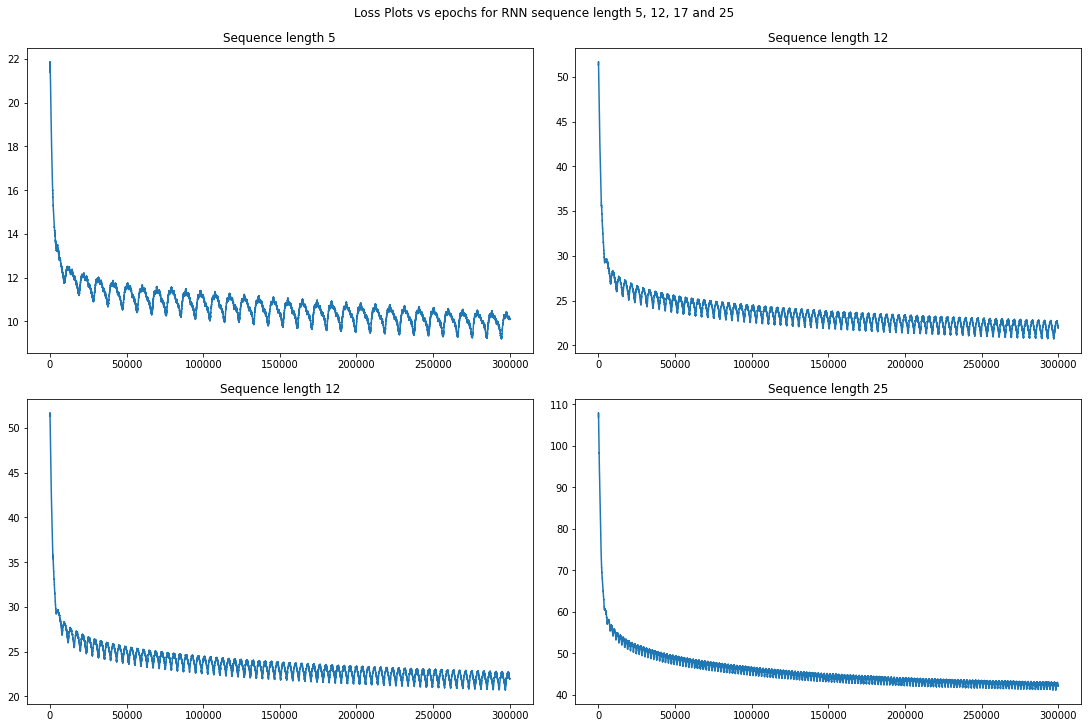

In [ ]:
# plot the loss for all sequences
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=2, ncols=2, constrained_layout=True, figsize=(15,10))
fig.suptitle('Loss Plots vs epochs for RNN sequence length 5, 12, 17 and 25', fontsize='large')

ax = axs[0, 0]
ax.plot(loss_dict[5])
ax.set_title("Sequence length 5")

ax = axs[0, 1]
ax.plot(loss_dict[12])
ax.set_title("Sequence length 12")

ax = axs[1, 0]
ax.plot(loss_dict[12])
ax.set_title("Sequence length 12")

ax = axs[1, 1]
ax.plot(loss_dict[25])
ax.set_title("Sequence length 25")

*** Comparison explanation:
1. The training time increased as the sequence length increased. This is similar to when the RNN was being trained for novel and golang.
2. Seasonality of zig zag pattern is observed. Overall there is a decreasing pattern.
3. Loss curve of lower sequence number goes to a lower value than higher value sequence numbers. However, by inspection, higher sequence number gives better roman urdu representation.